In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    average_precision_score
)
import shap
import random
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [23]:
# %%

# Configurações do Pandas e Matplotlib
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)


def carregar_dados_com_cache(nome_dataset, caminho_csv, url_api):
    if os.path.exists(caminho_csv):
        df = pd.read_csv(caminho_csv)
    else:
        try:
            df = pd.read_csv(url_api)
            df.to_csv(caminho_csv, index=False)
        except Exception as e:
            print(f"ERRO: Não foi possível buscar os dados da API para {nome_dataset}. Erro: {e}")
            return pd.DataFrame() # Retorna um DataFrame vazio em caso de erro

    print(f"{nome_dataset} carregado com sucesso. Shape: {df.shape}")
    return df

# --- DEFINIÇÃO DAS FONTES DE DADOS ---

# Nomes dos arquivos de cache que serão criados
KEPLER_CSV = 'nasa_data_kepler.csv'
TESS_CSV = 'nasa_data_tess.csv'
K2_CSV = 'nasa_data_k2.csv'

# URLs da API do NASA Exoplanet Archive
BASE_URL = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query="
KEPLER_QUERY = "select+*+from+cumulative"
TESS_QUERY = "select+*+from+toi"
K2_QUERY = "select+*+from+k2pandc"
FORMAT = "&format=csv"

# Montagem das URLs completas
kepler_url = f"{BASE_URL}{KEPLER_QUERY}{FORMAT}"
tess_url = f"{BASE_URL}{TESS_QUERY}{FORMAT}"
k2_url = f"{BASE_URL}{K2_QUERY}{FORMAT}"

# --- EXECUÇÃO DO CARREGAMENTO ---

kepler_df = carregar_dados_com_cache('Kepler', KEPLER_CSV, kepler_url)
tess_df = carregar_dados_com_cache('TESS', TESS_CSV, tess_url)
k2_df = carregar_dados_com_cache('K2', K2_CSV, k2_url)


Kepler carregado com sucesso. Shape: (9564, 153)
TESS carregado com sucesso. Shape: (7703, 91)
K2 carregado com sucesso. Shape: (4004, 361)


C:\Users\Guilherme\AppData\Local\Temp\ipykernel_15296\1175221431.py:11: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_csv)


In [24]:

# %%
# ==============================================================================
# 2. SELEÇÃO, RENOMEAÇÃO E PADRONIZAÇÃO
# ==============================================================================

# --- Processamento do Kepler (COM FILTRO DE AMBIGUIDADE) ---

# Disposições que queremos manter (alta confiança)
high_confidence_kepler = ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']
kepler_filtered_df = kepler_df.loc[kepler_df['koi_disposition'].isin(high_confidence_kepler)].copy()
print(f"Kepler: {len(kepler_df) - len(kepler_filtered_df)} linhas com baixa confiança removidas.")

# Mapeamento e criação do alvo (agora no DataFrame filtrado)
kepler_map = {
    'kepoi_name': 'transit_id',
    'koi_disposition': 'disposition',
    'koi_period': 'pl_period',
    'koi_duration': 'pl_transit_duration',
    'koi_prad': 'pl_radius',
    'koi_steff': 'st_eff_temp',
    'koi_srad': 'st_radius',
    'ra': 'ra',
    'dec': 'dec'
}
kepler_final = kepler_filtered_df[list(kepler_map.keys())].rename(columns=kepler_map)
kepler_final['source'] = 'Kepler'

true_planets_kepler = ['CONFIRMED', 'CANDIDATE']
kepler_final['isPlanet'] = kepler_final['disposition'].apply(lambda x: 1 if x in true_planets_kepler else 0)


Kepler: 0 linhas com baixa confiança removidas.


In [25]:
# --- Processamento do TESS (COM FILTRO DE AMBIGUIDADE) ---

# Disposições que queremos manter (alta confiança)
high_confidence_tess = ['PC', 'CP', 'KP', 'FP', 'FA'] # Removemos 'APC'
tess_filtered_df = tess_df.loc[tess_df['tfopwg_disp'].isin(high_confidence_tess)].copy()
print(f"TESS: {len(tess_df) - len(tess_filtered_df)} linhas com baixa confiança removidas.")

# Mapeamento e criação do alvo (agora no DataFrame filtrado)
tess_map = {
    'toi': 'transit_id',
    'tfopwg_disp': 'disposition',
    'pl_orbper': 'pl_period',
    'pl_trandurh': 'pl_transit_duration',
    'pl_rade': 'pl_radius',
    'st_teff': 'st_eff_temp',
    'st_rad': 'st_radius',
    'ra': 'ra',
    'dec': 'dec'
}
tess_final = tess_filtered_df[list(tess_map.keys())].rename(columns=tess_map)
tess_final['source'] = 'TESS'

true_planets_tess = ['PC', 'CP', 'KP']
tess_final['isPlanet'] = tess_final['disposition'].apply(lambda x: 1 if x in true_planets_tess else 0)


TESS: 462 linhas com baixa confiança removidas.


In [26]:
# --- Processamento do K2 (COM FILTRO DE AMBIGUIDADE) ---

# Filtrar K2
print(f"K2 antes do filtro 'default_flag': {k2_df.shape[0]} linhas")
k2_df = k2_df[k2_df['default_flag'] == 1].copy()
print(f"K2 depois do filtro 'default_flag': {k2_df.shape[0]} linhas")
# --- Processamento do K2 ---
k2_map = {
	'pl_name': 'transit_id',
	'disposition': 'disposition',
	'pl_orbper': 'pl_period',
	'pl_trandur': 'pl_transit_duration',
	'pl_rade': 'pl_radius',
	'st_teff': 'st_eff_temp',
	'st_rad': 'st_radius',
	'ra': 'ra',
	'dec': 'dec'
}
k2_final = k2_df[list(k2_map.keys())].rename(columns=k2_map)
k2_final['source'] = 'K2'


# Criar a variável alvo 'isPlanet'
# CONFIRMED, CANDIDATE -> 1
# FALSE POSITIVE -> 0
true_planets_k2 = ['CONFIRMED', 'CANDIDATE']
k2_final['isPlanet'] = k2_final['disposition'].apply(lambda x: 1 if x in true_planets_k2 else 0)


K2 antes do filtro 'default_flag': 4004 linhas
K2 depois do filtro 'default_flag': 1806 linhas


In [27]:
print("\nProcessamento concluído.")
print(f"Kepler final: {kepler_final.shape}")
print(f"TESS final: {tess_final.shape}")
print(f"K2 final: {k2_final.shape}")


Processamento concluído.
Kepler final: (9564, 11)
TESS final: (7241, 11)
K2 final: (1806, 11)


In [28]:


# %%
# ==============================================================================
# 3. CONCATENAÇÃO E LIMPEZA FINAL
# ==============================================================================
final_df = pd.concat([kepler_final, tess_final, k2_final], ignore_index=True)

# Remover a coluna original de disposição, pois já temos 'isPlanet'
final_df = final_df.drop(columns=['disposition'])

print(f"\nDataset unificado criado. Shape: {final_df.shape}")


final_df


Dataset unificado criado. Shape: (18611, 10)


,transit_id,pl_period,pl_transit_duration,pl_radius,st_eff_temp,st_radius,ra,dec,source,isPlanet
0,K00752.01,9.488036,2.95750,2.26,5455.00,0.92700,291.934230,48.141651,Kepler,1
1,K00752.02,54.418383,4.50700,2.83,5455.00,0.92700,291.934230,48.141651,Kepler,1
2,K00753.01,19.899140,1.78220,14.60,5853.00,0.86800,297.004820,48.134129,Kepler,1
3,K00754.01,1.736952,2.40641,33.46,5805.00,0.79100,285.534610,48.285210,Kepler,0
4,K00755.01,2.525592,1.65450,2.75,6031.00,1.04600,288.754880,48.226200,Kepler,1
...,...,...,...,...,...,...,...,...,...,...
18606,EPIC 211590050.01,26.000000,NaN,10.48,6414.00,1.57000,135.080358,14.404259,K2,1
18607,EPIC 211796070.01,1.889930,1.65600,1.29,NaN,0.63800,128.310980,17.261418,K2,1
18608,EPIC 212044495.01,1.830767,2.84880,NaN,6141.42,0.98712,137.317315,21.002565,K2,0
18609,EPIC 220542353.01,15.246593,3.76080,78.00,NaN,1.91000,14.744463,7.719319,K2,1


In [29]:
#shape antes de remover os nulos
print("Shape antes de remover os nulos:", final_df.shape)

#limpa todos os valores nulos
df_cleaned = final_df.dropna()

#shape após remover os nulos
print("Shape após remover os nulos:", df_cleaned.shape)

data_final = df_cleaned.copy()

Shape antes de remover os nulos: (18611, 10)
Shape após remover os nulos: (16346, 10)


In [30]:
# distribuição de isPlanet no k2
data_final[data_final['source'] == 'K2']['isPlanet'].value_counts()

isPlanet
1    469
0     18
Name: count, dtype: int64


--- Informações Gerais do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18611 entries, 0 to 18610
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transit_id           18611 non-null  object 
 1   pl_period            18486 non-null  float64
 2   pl_transit_duration  18136 non-null  float64
 3   pl_radius            17418 non-null  float64
 4   st_eff_temp          17503 non-null  float64
 5   st_radius            17721 non-null  float64
 6   ra                   18611 non-null  float64
 7   dec                  18611 non-null  float64
 8   source               18611 non-null  object 
 9   isPlanet             18611 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 1.4+ MB

--- Estatísticas Descritivas ---


,pl_period,pl_transit_duration,pl_radius,st_eff_temp,st_radius,ra,dec,isPlanet
count,18486.000000,18136.000000,17418.000000,17503.000000,17721.000000,18611.000000,18611.000000,18611.000000
mean,52.820935,4.458760,59.226377,5698.744750,1.568632,237.178902,23.241579,0.656977
std,1144.815587,5.053448,2237.301346,1150.397705,4.639174,90.557175,36.947689,0.474732
min,0.163821,0.000000,0.080000,2566.000000,0.109000,0.084680,-89.471513,0.000000
25%,2.616465,2.141950,1.880000,5222.000000,0.830000,168.769217,6.263794,0.000000
50%,5.773456,3.220050,4.183515,5754.000000,1.047000,288.224370,40.657040,1.000000
75%,17.451381,4.888200,13.708732,6153.000000,1.506000,295.054735,46.054743,1.000000
max,129995.778400,138.540000,200346.000000,50000.000000,229.908000,359.941195,89.086923,1.000000



--- Contagem de Valores Nulos por Coluna ---
pl_radius              1193
st_eff_temp            1108
st_radius               890
pl_transit_duration     475
pl_period               125
transit_id                0
ra                        0
dec                       0
source                    0
isPlanet                  0
dtype: int64


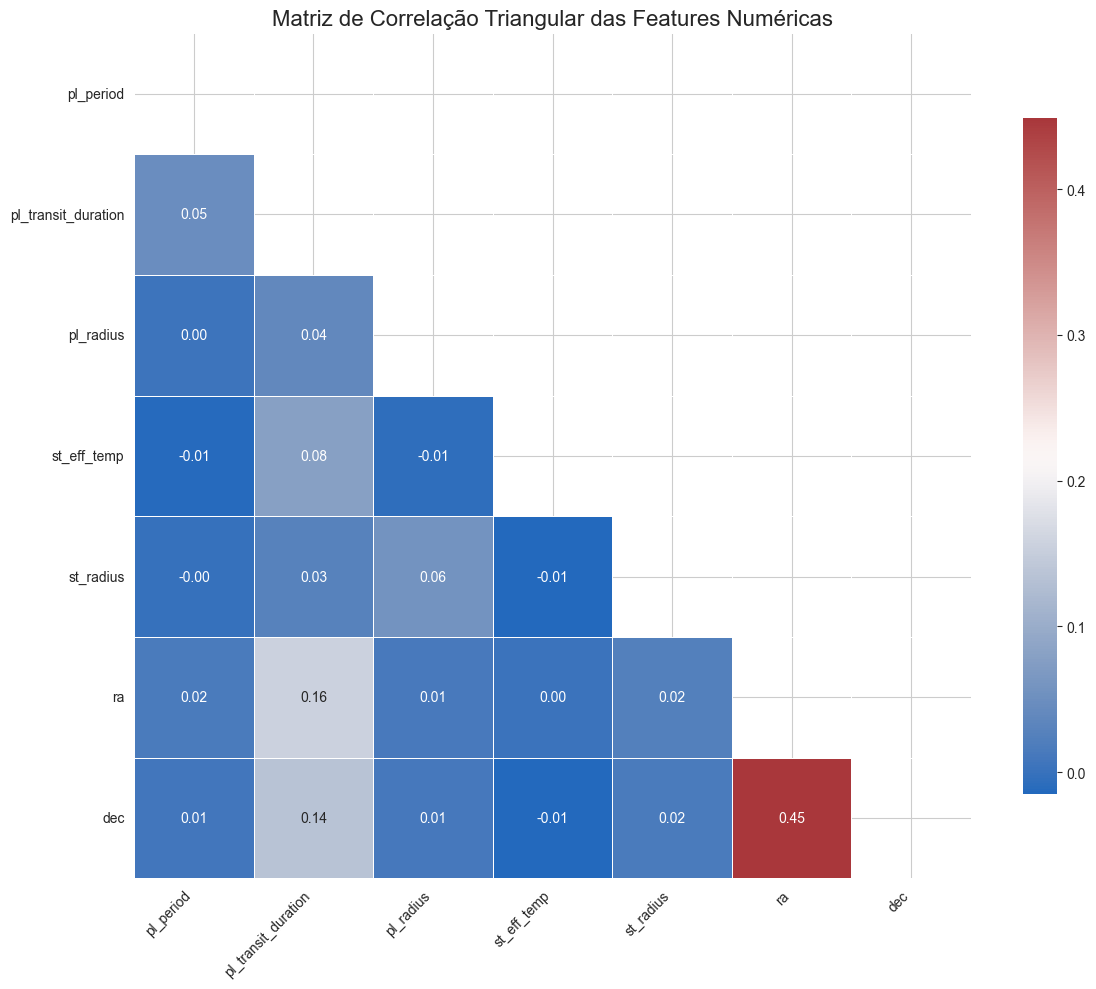

In [31]:


# %%
# ==============================================================================
# 4. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
# ==============================================================================

# # --- Informações Gerais e Estatísticas Descritivas ---
print("\n--- Informações Gerais do Dataset ---")
final_df.info()

print("\n--- Estatísticas Descritivas ---")
display(final_df.describe())

# --- Verificação de Valores Nulos ---
print("\n--- Contagem de Valores Nulos por Coluna ---")
print(final_df.isnull().sum().sort_values(ascending=False))

# # --- Distribuição da Variável Alvo e da Origem dos Dados ---
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# sns.countplot(x='isPlanet', data=final_df)
# plt.title('Distribuição da Variável Alvo (isPlanet)')
# plt.xlabel('0: Falso Positivo | 1: Planeta/Candidato')

# plt.subplot(1, 2, 2)
# sns.countplot(x='source', data=final_df, order=final_df['source'].value_counts().index)
# plt.title('Distribuição da Origem dos Dados')
# plt.tight_layout()
# plt.show()

# # # --- Distribuição das Features Numéricas ---
numeric_features = final_df.select_dtypes(include=np.number).columns.drop('isPlanet')
# for col in numeric_features:
#     plt.figure(figsize=(14, 6))
    
#     # Histograma com escala linear
#     plt.subplot(1, 2, 1)
#     sns.histplot(data=final_df, x=col, hue='isPlanet', kde=True, palette='viridis')
#     plt.title(f'Distribuição de {col} (Escala Linear)')
    
#     # Histograma com escala logarítmica (útil para dados com grande amplitude)
#     plt.subplot(1, 2, 2)
#     # Adicionar um pequeno valor para evitar log(0)
#     log_data = np.log1p(final_df[col].dropna())
#     sns.histplot(x=log_data, hue=final_df.loc[final_df[col].notna(), 'isPlanet'], kde=True, palette='plasma')
#     plt.title(f'Distribuição de {col} (Escala Log)')
#     plt.xlabel(f'log({col})')
    
#     plt.tight_layout()
#     plt.show()

# --- Matriz de Correlação (VERSÃO MELHORADA) ---
plt.figure(figsize=(12, 10))

# 1. Calcula a matriz de correlação normalmente
correlation_matrix = final_df[numeric_features].corr()

# 2. Cria uma máscara para o triângulo superior (incluindo a diagonal)
#    - np.ones_like(correlation_matrix, dtype=bool) cria uma matriz do mesmo tamanho, toda com 'True'.
#    - np.triu(...) transforma essa matriz, mantendo 'True' apenas na diagonal superior.
#    - O heatmap do seaborn usa essa máscara para NÃO desenhar as células onde o valor é 'True'.
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 3. Desenha o heatmap com as melhorias aplicadas
sns.heatmap(
    correlation_matrix,
    mask=mask,              # Aplica a máscara para esconder a parte superior e a diagonal
    annot=True,             # Mantém a anotação dos valores
    fmt=".2f",              # Formata os números com duas casas decimais
    cmap='vlag',            # Uma paleta de cores divergente e profissional (azul para negativo, vermelho para positivo)
    linewidths=.5,          # Adiciona uma pequena linha divisória entre as células
    cbar_kws={"shrink": .8} # Diminui um pouco o tamanho da barra de cores lateral
)

# 4. Ajustes finais de layout para melhor visualização
plt.title('Matriz de Correlação Triangular das Features Numéricas', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotaciona os labels do eixo X para não se sobreporem
plt.yticks(rotation=0)              # Mantém os labels do eixo Y na horizontal
plt.tight_layout()                  # Ajusta o plot para garantir que tudo caiba na figura
plt.show()

In [32]:
# ==============================================================================
# 4. PREPARAÇÃO PARA MODELAGEM (VERSÃO ATUALIZADA COM ID)
# ==============================================================================
from sklearn.model_selection import GroupShuffleSplit

# --- Criar um ID de Agrupamento (star_id) ---
data_final['star_id'] = data_final['ra'].astype(str) + '_' + data_final['dec'].astype(str)


# Numero total de linhas
num_rows = data_final.shape[0]
print(f"Número total de linhas no dataset: {num_rows}")

# Numero de estrelas unicas
num_stars = data_final['star_id'].nunique()
print(f"\nNúmero de sistemas estelares únicos (star_id): {num_stars}")

# --- Separar colunas de features, metadados e alvo ---
# O ID do trânsito é um metadado, não uma feature para o modelo aprender!
metadata_cols = ['transit_id', 'star_id', 'source', 'ra', 'dec']
target_col = 'isPlanet'
feature_cols = [col for col in data_final.columns if col not in metadata_cols + [target_col]]

print("Features que serão usadas no modelo:", feature_cols)

# --- Dividir os dados em treino e teste (hold-out) usando GroupShuffleSplit ---
# Esta é a forma mais correta de garantir que não há vazamento de dados
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_idx, test_idx = next(gss.split(data_final[feature_cols], data_final[target_col], data_final['star_id']))

train_df = data_final.iloc[train_idx]
test_df = data_final.iloc[test_idx]

print(f"\nDados separados (respeitando os sistemas estelares):")
print(f"  - Conjunto de Treino/Validação: {train_df.shape[0]} amostras")
print(f"  - Conjunto de Teste (Hold-Out): {test_df.shape[0]} amostras")

# --- Exportar o conjunto de teste para um CSV (COM O ID) ---
csv_filename = 'dados_para_predicao.csv'
# Criamos o CSV apenas com o ID e as features necessárias para a predição
test_df[['transit_id'] + feature_cols].to_csv(csv_filename, index=False)
print(f"\nDados de teste com ID salvos em '{csv_filename}'")

# --- Preparar variáveis para o restante do script de treinamento ---
X = train_df[feature_cols]
y = train_df[target_col]
groups = train_df['star_id']

Número total de linhas no dataset: 16346

Número de sistemas estelares únicos (star_id): 14725
Features que serão usadas no modelo: ['pl_period', 'pl_transit_duration', 'pl_radius', 'st_eff_temp', 'st_radius']

Dados separados (respeitando os sistemas estelares):
  - Conjunto de Treino/Validação: 13895 amostras
  - Conjunto de Teste (Hold-Out): 2451 amostras

Dados de teste com ID salvos em 'dados_para_predicao.csv'


In [ ]:
# # %%
# # ==============================================================================
# # 5a. OTIMIZAÇÃO DE HIPERPARÂMETROS COM OPTUNA PARA LIGHTGBM
# # ==============================================================================
# import optuna

# # Desativa o logging detalhado do Optuna para manter a saída mais limpa
# optuna.logging.set_verbosity(optuna.logging.ERROR)

# def objective(trial, X, y, groups):
#     """
#     Função objetivo que o Optuna tentará maximizar.
#     Ela treina e avalia um modelo LightGBM com os hiperparâmetros sugeridos pelo 'trial'.
#     """
#     # Definindo o espaço de busca dos hiperparâmetros
#     param = {
#         'objective': 'binary',
#         'metric': 'auc',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'random_state': SEED,
#         'class_weight': 'balanced',
#         'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 500),
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#     }

#     model = LGBMClassifier(**param)
    
#     # Validação cruzada para avaliar a performance desta combinação de hiperparâmetros
#     cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
#     roc_aucs = []

#     for train_idx, val_idx in cv.split(X, y, groups):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
#         # A padronização deve ocorrer dentro de cada fold
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_val_scaled = scaler.transform(X_val)

#         model.fit(X_train_scaled, y_train)
#         y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
#         roc_aucs.append(roc_auc_score(y_val, y_pred_proba))

#     # Retorna a média da métrica (AUC ROC) entre os folds
#     return np.mean(roc_aucs)

# print("\nIniciando a otimização de hiperparâmetros para LightGBM com Optuna...")

# # Configurando o Sampler TPE com a opção 'multivariate' para capturar interações entre hiperparâmetros
# sampler = optuna.samplers.TPESampler(multivariate=True, seed=SEED)

# # Configurando o Pruner para cortar "trials" (tentativas) ruins mais cedo
# pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)

# # Criando o estudo do Optuna
# study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

# # Executando a otimização
# # O lambda é usado para passar os argumentos extras (X, y, groups) para a função objective
# study.optimize(lambda trial: objective(trial, X, y, groups), n_trials=500, show_progress_bar=True, timeout=7200)

# print("Otimização concluída!")
# print(f"Melhor valor (AUC ROC médio): {study.best_value:.4f}")
# print("Melhores hiperparâmetros encontrados:")
# print(study.best_params)

# # Criando o modelo final do LightGBM com os melhores parâmetros encontrados
# lgbm_optuna_params = study.best_params
# lgbm_optuna_params['random_state'] = SEED
# lgbm_optuna_params['class_weight'] = 'balanced' 

# lgbm_optuna_model = LGBMClassifier(**lgbm_optuna_params)


Iniciando a otimização de hiperparâmetros para LightGBM com Optuna...


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\P

KeyboardInterrupt: 

In [35]:
# %%
# ==============================================================================
# 5. DEFINIÇÃO E TREINAMENTO DOS MODELOS (DO SCRIPT 2)
# ==============================================================================

count_neg = y.value_counts().get(0, 0)
count_pos = y.value_counts().get(1, 0)
scale_pos_weight = count_neg / count_pos if count_pos > 0 else 1
print(f"\nScale Pos Weight para XGBoost: {scale_pos_weight:.2f}")


models = {
    "XGBoost": XGBClassifier(random_state=SEED, eval_metric='logloss', scale_pos_weight=scale_pos_weight),
    "XGBoost (Tunado)": XGBClassifier(
        random_state=SEED, eval_metric='logloss', scale_pos_weight=scale_pos_weight,
        n_estimators=600, learning_rate=0.04, max_depth=6, subsample=0.8, colsample_bytree=0.8
    ),
    "LightGBM": LGBMClassifier(random_state=SEED, class_weight='balanced', verbosity=-1),
    "LightGBM (Tunado)": LGBMClassifier(
        random_state=SEED, class_weight='balanced', n_estimators=500, learning_rate=0.05, verbosity=-1
    ),
	"LightGBM (Optuna saved)": LGBMClassifier(
		random_state=SEED, class_weight='balanced', n_estimators=1600, learning_rate=0.002865832106246123,
		lambda_l1=1.1212412169964432e-08, lambda_l2=0.2183498289760726, num_leaves=359, max_depth=10,
		feature_fraction=0.8856351733429728, bagging_fraction=0.5370223258670452, bagging_freq=3, min_child_samples=16,
		verbosity=-1
	),
	"LightGBM (Optuna v2)": LGBMClassifier(
		random_state=SEED, class_weight='balanced', n_estimators=2000, learning_rate=0.0035815868161219455,
		lambda_l1=1.163030696467602e-06, lambda_l2=0.030932994222052305, num_leaves=230, max_depth=8,
		feature_fraction=0.9029085304482941, bagging_fraction=0.5018787981793469, bagging_freq=2, min_child_samples=46,
		verbosity=-1
	),
	# "LightGBM (Optuna new)": lgbm_optuna_model
}


Scale Pos Weight para XGBoost: 0.54


In [36]:
# ==============================================================================
# 6. VALIDAÇÃO CRUZADA E AVALIAÇÃO (COM OTIMIZAÇÃO DE THRESHOLD)
# ==============================================================================
from sklearn.metrics import precision_recall_curve, f1_score

results = []
n_splits = 5
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

for name, model in models.items():
    print(f"\nValidando o modelo: {name}...")
    fold_roc_aucs, fold_prc_aucs, fold_accuracies = [], [], []
    fold_f1_planet, fold_f1_fp = [], []
    fold_prec_planet, fold_rec_planet = [], []
    fold_prec_non_planet, fold_rec_non_planet = [], []
    fold_best_thresholds = []

    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y, groups)):
        print(f"  - Processando Fold {fold+1}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Padronização dos dados DENTRO do loop
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]

        # --- INÍCIO DA OTIMIZAÇÃO DE THRESHOLD ---
        # 1. Calcula precisão, recall para vários thresholds
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

        # 2. Calcula o F1-score para cada threshold (evitando divisão por zero)
        f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)

        # 3. Encontra o melhor threshold que maximiza o F1-score
        best_threshold_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_threshold_idx]
        fold_best_thresholds.append(best_threshold)

        # 4. Usa o melhor threshold para fazer a predição final
        y_pred = (y_pred_proba >= best_threshold).astype(int)
        # --- FIM DA OTIMIZAÇÃO DE THRESHOLD ---


        # Calcular métricas com o y_pred otimizado
        fold_roc_aucs.append(roc_auc_score(y_val, y_pred_proba)) # ROC AUC não muda com o threshold
        fold_prc_aucs.append(average_precision_score(y_val, y_pred_proba)) # PRC AUC também não
        fold_accuracies.append(accuracy_score(y_val, y_pred))

        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        
        fold_f1_planet.append(report.get('1', {}).get('f1-score', 0))
        fold_prec_planet.append(report.get('1', {}).get('precision', 0))
        fold_rec_planet.append(report.get('1', {}).get('recall', 0))
        fold_prec_non_planet.append(report.get('0', {}).get('precision', 0))
        fold_rec_non_planet.append(report.get('0', {}).get('recall', 0))
        fold_f1_fp.append(report.get('0', {}).get('f1-score', 0))

    results.append({
        "Modelo": name,
        "Threshold Ótimo": np.mean(fold_best_thresholds), # <-- NOVO: Adiciona o threshold médio
        "AUC ROC Média": np.mean(fold_roc_aucs),
        "AUC PRC Média": np.mean(fold_prc_aucs),
        "Acurácia Média": np.mean(fold_accuracies),
        "Precisão (Planeta) Média": np.mean(fold_prec_planet),
        "Recall (Planeta) Média": np.mean(fold_rec_planet),
        "Precisão (Non Planet) Média": np.mean(fold_prec_non_planet),
        "Recall (Non Planet) Média": np.mean(fold_rec_non_planet),
        "F1 (Planeta) Média": np.mean(fold_f1_planet),
        "F1 (Non Planet) Média": np.mean(fold_f1_fp)
    })

print("\nTodos os modelos foram avaliados.")

results_df = pd.DataFrame(results).sort_values(by="AUC ROC Média", ascending=False)




Validando o modelo: XGBoost...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: XGBoost (Tunado)...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: LightGBM...
  - Processando Fold 1/5
  - Processando Fold 2/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 3/5
  - Processando Fold 4/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 5/5

Validando o modelo: LightGBM (Tunado)...
  - Processando Fold 1/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 2/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 3/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 4/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 5/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Validando o modelo: LightGBM (Optuna saved)...
  - Processando Fold 1/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 2/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 3/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 4/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 5/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Validando o modelo: LightGBM (Optuna v2)...
  - Processando Fold 1/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 2/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 3/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 4/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 5/5

Todos os modelos foram avaliados.


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [37]:
# Adicionar formatação para as novas colunas
display(results_df.style.format({
	'AUC ROC Média': '{:.4f}', 'AUC ROC Std': '{:.4f}', 'AUC PRC Média': '{:.4f}',
	'Acurácia Média': '{:.4f}', 'F1 (Planeta) Média': '{:.4f}', 
	'Precisão (Planeta) Média': '{:.4f}', 'Recall (Planeta) Média': '{:.4f}', # <-- NOVA LINHA
	'F1 (Non Planet) Média': '{:.4f}'
}).background_gradient(cmap='viridis', subset=['AUC ROC Média', 'AUC PRC Média', 'F1 (Planeta) Média']))

,Modelo,Threshold Ótimo,AUC ROC Média,AUC PRC Média,Acurácia Média,Precisão (Planeta) Média,Recall (Planeta) Média,Precisão (Non Planet) Média,Recall (Non Planet) Média,F1 (Planeta) Média,F1 (Non Planet) Média
5,LightGBM (Optuna v2),0.320357,0.9003,0.9318,0.8429,0.8417,0.9338,0.846780,0.675053,0.8852,0.7509
4,LightGBM (Optuna saved),0.360181,0.9000,0.9321,0.8427,0.8461,0.9264,0.834915,0.687947,0.8844,0.7541
2,LightGBM,0.321404,0.8971,0.9279,0.8389,0.8379,0.9322,0.841922,0.665787,0.8825,0.7432
1,XGBoost (Tunado),0.332025,0.8946,0.9260,0.8388,0.8403,0.9283,0.836334,0.673415,0.8820,0.7456
3,LightGBM (Tunado),0.332344,0.8945,0.9248,0.8377,0.8400,0.9265,0.831984,0.673461,0.8811,0.7442
0,XGBoost,0.279913,0.8895,0.9215,0.8336,0.8290,0.9381,0.850827,0.641199,0.8798,0.7294


In [38]:
# %%
# ==============================================================================
# 7. TREINAMENTO DO PIPELINE FINAL
# ==============================================================================
best_model_name = results_df.iloc[0]['Modelo']
best_model = models[best_model_name]

print(f"\nO melhor modelo foi: '{best_model_name}'")

final_scaler = StandardScaler()
X_scaled_final = final_scaler.fit_transform(X)

print("Treinando o modelo final com todos os dados...")
best_model.fit(X_scaled_final, y)
print("Modelo final treinado com sucesso!")




O melhor modelo foi: 'LightGBM (Optuna v2)'
Treinando o modelo final com todos os dados...
Modelo final treinado com sucesso!


In [39]:
# %%
# ==============================================================================
# 8. SALVAR O MODELO E O SCALER PARA PRODUÇÃO
# ==============================================================================
import joblib

# Definir os nomes dos arquivos
model_filename = 'modelo_exoplanetas.joblib'
scaler_filename = 'scaler_exoplanetas.joblib'

# Salvar o modelo treinado
joblib.dump(best_model, model_filename)
print(f"Modelo salvo com sucesso em: '{model_filename}'")

# Salvar o objeto scaler treinado
joblib.dump(final_scaler, scaler_filename)
print(f"Scaler salvo com sucesso em: '{scaler_filename}'")

Modelo salvo com sucesso em: 'modelo_exoplanetas.joblib'
Scaler salvo com sucesso em: 'scaler_exoplanetas.joblib'


In [40]:
# ==============================================================================
# 8. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE E EXPORTAÇÃO (VERSÃO CORRIGIDA E COM THRESHOLD)
# ==============================================================================
import json
import pandas as pd
pd.options.mode.chained_assignment = None


best_model_threshold = results_df[results_df['Modelo'] == best_model_name]['Threshold Ótimo'].values[0]
print(f"Usando o Threshold Ótimo de {best_model_threshold:.4f} para o modelo '{best_model_name}'")

X_test_holdout = test_df[feature_cols]
y_test_holdout = test_df[target_col]
X_test_holdout_scaled = final_scaler.transform(X_test_holdout)


y_pred_proba_holdout = best_model.predict_proba(X_test_holdout_scaled)[:, 1]

# <-- MUDANÇA PRINCIPAL: Aplicando o threshold otimizado -->
y_pred_holdout = (y_pred_proba_holdout >= best_model_threshold).astype(int)


test_df['prediction'] = y_pred_holdout
test_df['prediction_proba'] = y_pred_proba_holdout


per_satellite_metrics = {}
for satellite_source in test_df['source'].unique():
	subset_df = test_df[test_df['source'] == satellite_source]
	
	if subset_df.empty:
		continue

	y_true_sat = subset_df['isPlanet']
	y_pred_sat = subset_df['prediction']
	y_proba_sat = subset_df['prediction_proba']
		
	report = classification_report(y_true_sat, y_pred_sat, output_dict=True, zero_division=0)
	
	roc_auc = np.nan
	if len(y_true_sat.unique()) > 1:
		roc_auc = roc_auc_score(y_true_sat, y_proba_sat)

	per_satellite_metrics[satellite_source] = {
		'acuracia': accuracy_score(y_true_sat, y_pred_sat),
		'recall_planeta': report.get('1', {}).get('recall', 0),
		'precisao_planeta': report.get('1', {}).get('precision', 0),
		'f1_score_planeta': report.get('1', {}).get('f1-score', 0),
		'auc_roc': roc_auc
	}


print("\n--- Métricas GLOBAIS no conjunto de teste (hold-out) ---")

# 1. CALCULAR MÉTRICAS GLOBAIS
global_report = classification_report(y_test_holdout, y_pred_holdout, output_dict=True, zero_division=0)
global_roc_auc = roc_auc_score(y_test_holdout, y_pred_proba_holdout)
global_prc_auc = average_precision_score(y_test_holdout, y_pred_proba_holdout)

global_test_metrics = {
    'acuracia': global_report.get('accuracy', 0),
    'auc_roc': global_roc_auc,
    'auc_prc': global_prc_auc,
    'recall_planeta': global_report.get('1', {}).get('recall', 0),
    'precisao_planeta': global_report.get('1', {}).get('precision', 0),
    'f1_score_planeta': global_report.get('1', {}).get('f1-score', 0)
}

# 2. COMBINAR TODAS AS MÉTRICAS (GLOBAIS E POR SATÉLITE) EM UM ÚNICO DATAFRAME
# Adiciona as métricas globais ao dicionário de métricas por satélite
all_metrics = per_satellite_metrics.copy()
all_metrics['Global'] = global_test_metrics

# Converte o dicionário completo para um DataFrame do Pandas
metrics_table_df = pd.DataFrame.from_dict(all_metrics, orient='index')

# Reordena as colunas para uma visualização mais lógica
metrics_table_df = metrics_table_df[['acuracia', 'auc_roc', 'f1_score_planeta', 'precisao_planeta', 'recall_planeta']]

# Renomeia as colunas para ficarem mais claras na tabela
metrics_table_df.columns = ['Acurácia', 'AUC ROC', 'F1 (Planeta)', 'Precisão (Planeta)', 'Recall (Planeta)']

# 3. EXIBIR A TABELA ESTILIZADA
print("\nTabela de Métricas Finais no Conjunto de Teste:")
display(metrics_table_df.style.format('{:.4f}').background_gradient(cmap='viridis', axis=0))


# 4. SALVAR TUDO NO JSON FINAL (INCLUINDO AS MÉTRICAS GLOBAIS)
final_metrics_to_export = {
    "comparacao_modelos_cv": results_df.to_dict(orient='records'),
    "metricas_globais_teste": global_test_metrics,
    "metricas_por_satelite_teste": per_satellite_metrics
}

json_filename = 'resultados_completos_modelo.json'
with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(final_metrics_to_export, f, indent=4, ensure_ascii=False)
print(f"\nTodas as métricas foram salvas com sucesso em: '{json_filename}'")

Usando o Threshold Ótimo de 0.3204 para o modelo 'LightGBM (Optuna v2)'


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Métricas GLOBAIS no conjunto de teste (hold-out) ---

Tabela de Métricas Finais no Conjunto de Teste:


,Acurácia,AUC ROC,F1 (Planeta),Precisão (Planeta),Recall (Planeta)
Kepler,0.8388,0.9212,0.8490,0.8023,0.9015
TESS,0.8384,0.7847,0.9061,0.8667,0.9492
K2,0.8077,0.8400,0.8889,1.0000,0.8000
Global,0.8376,0.8969,0.8792,0.8415,0.9206



Todas as métricas foram salvas com sucesso em: 'resultados_completos_modelo.json'


In [ ]:
# # %%
# # ==============================================================================
# # 9. ANÁLISE ROBUSTA DE IMPORTÂNCIA DAS FEATURES
# # ==============================================================================
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import shap
# from sklearn.inspection import permutation_importance

# # Garantir que as variáveis necessárias do script principal estão disponíveis:
# # best_model, X, X_scaled_final, feature_cols
# # test_df, feature_cols, target_col, final_scaler

# print(f"\n--- Iniciando Análise de Features para o modelo: {best_model_name} ---")

# # Preparar os dados de teste para a Permutation Importance
# X_test_holdout = test_df[feature_cols]
# y_test_holdout = test_df[target_col]
# X_test_holdout_scaled = final_scaler.transform(X_test_holdout)


# # %% [markdown]
# # ### 9.1. Usando a Feature Importance Embutida do Modelo
# # 
# # **O que é e por que usar?**
# # Esta é a maneira mais rápida de obter a importância das features, pois ela é calculada durante o treinamento do modelo. Para modelos como LightGBM e XGBoost, temos principalmente dois tipos:
# # 
# # * **Gain (Ganho):** A contribuição média de cada feature para a redução do erro (impureza) do modelo. **Geralmente, é a métrica mais confiável e recomendada.**
# # * **Split (Divisões):** O número de vezes que uma feature foi usada para dividir um nó em uma árvore. É mais simples, mas pode favorecer features numéricas com muitos valores únicos.

# # %%
# def plotar_importancia_nativa(modelo, feature_names):
#     """
#     Plota as importâncias de features nativas ('gain' e 'split') para modelos
#     LightGBM ou XGBoost de forma organizada.
#     """
#     if isinstance(modelo, LGBMClassifier):
#         importances = {
#             'gain': modelo.feature_importances_ / modelo.feature_importances_.sum(),
#             'split': modelo.booster_.feature_importance(importance_type='split')
#         }
#         model_type = 'LightGBM'
#     elif isinstance(modelo, XGBClassifier):
#         importances = {
#             'gain': modelo.feature_importances_
#         }
#         model_type = 'XGBoost'
#     else:
#         print(f"Modelo do tipo {type(modelo).__name__} não suportado por esta função.")
#         return

#     fig, axes = plt.subplots(1, len(importances), figsize=(8 * len(importances), 10), squeeze=False)
#     fig.suptitle(f'Importância de Features Nativa do Modelo ({model_type})', fontsize=20)
    
#     for i, (imp_type, imp_values) in enumerate(importances.items()):
#         df_imp = pd.DataFrame({'feature': feature_names, 'importance': imp_values})
#         df_imp = df_imp.sort_values('importance', ascending=False).head(20) # Top 20

#         ax = axes[0, i]
#         sns.barplot(x='importance', y='feature', data=df_imp, ax=ax, palette='viridis')
#         ax.set_title(f'Por {imp_type.capitalize()}', fontsize=16)
#         ax.set_xlabel('Importância Relativa', fontsize=12)
#         ax.set_ylabel('Feature', fontsize=12)

#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

# # Gerar os gráficos de importância nativa
# plotar_importancia_nativa(best_model, feature_cols)



# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_scaled_final)

# shap.summary_plot(shap_values, X, plot_type="dot", show=True)
# shap.summary_plot(shap_values, X, plot_type="bar", show=True)


# # Pega as features mais importantes com base no valor médio de SHAP
# shap_sum = np.abs(shap_values).mean(axis=0)
# top_features_indices = np.argsort(shap_sum)[-4:] # Pega o índice das 4 mais importantes
# top_features_names = X.columns[top_features_indices]

# for feature_name in reversed(top_features_names): # reversed para começar pela mais importante
#     print(f" -> Gráfico de dependência para '{feature_name}'")
#     shap.dependence_plot(feature_name, shap_values, X, interaction_index="auto", show=True)



# print("\nCalculando a Importância por Permutação no conjunto de teste... (Pode levar um momento)")

# # Usamos o AUC ROC como métrica de scoring
# perm_importance = permutation_importance(
#     best_model,
#     X_test_holdout_scaled,
#     y_test_holdout,
#     n_repeats=10,
#     random_state=SEED,
#     scoring='roc_auc'
# )

# # Organizando os resultados
# sorted_idx = perm_importance.importances_mean.argsort()

# fig, ax = plt.subplots(figsize=(12, 8))
# ax.boxplot(
#     perm_importance.importances[sorted_idx].T,
#     vert=False,
#     labels=X.columns[sorted_idx]
# )
# ax.set_title("Importância por Permutação (no Conjunto de Teste)", fontsize=16)
# ax.set_xlabel("Queda na performance (AUC ROC)", fontsize=12)
# fig.tight_layout()
# plt.show()